# Support vector machines

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
sns.set()

# Load data
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    cifar_train = dict(npz_file.items())
print('It is a dictionary with keys:', list(cifar_train.keys()))
#cifar_train  

It is a dictionary with keys: ['pixels', 'overfeat', 'labels', 'names', 'allow_pickle']


In [2]:
# Create X/y arrays
X = cifar_train['overfeat']
y = cifar_train['labels']
names = cifar_train['names']
pixels = cifar_train['pixels'].astype(np.float32)
pixels = pixels / 255

print('X:', X.shape, X.dtype)
print('y:', y.shape, y.dtype)
print('pixels:', pixels.shape, pixels.dtype)
print('names:', names)

X: (5000, 4096) float32
y: (5000,) int64
pixels: (5000, 3072) float32
names: ['truck' 'car' 'airplane' 'ship']


In [3]:
# Reshape images: 32 by 32 with 3 (RGB) color channels
pixels_reshaped = pixels.reshape(-1, 32, 32, 3)
print('pixels_reshaped:', pixels_reshaped.shape, pixels_reshaped.dtype)
#print(pixels_reshaped)

pixels_reshaped: (5000, 32, 32, 3) float32


In [4]:
from sklearn.model_selection import train_test_split

# Convert the type of the input matrix to float
X = X.astype(np.float)

# Split data into train/test sets
X_tr, X_te, y_tr, y_te, Pix_tr, Pix_te = train_test_split(
    X, y, pixels, train_size=4000, test_size=1000, random_state=0, stratify=y)
print('Train set:', X_tr.shape, y_tr.shape)
print('Test set:', X_te.shape, y_te.shape)
print('Pixels set:', Pix_tr.shape, Pix_te.shape)

Train set: (4000, 4096) (4000,)
Test set: (1000, 4096) (1000,)
Pixels set: (4000, 3072) (1000, 3072)


In [5]:
# overfeat data: 176 values = 90% of the variance explained
from sklearn.preprocessing import StandardScaler
features=pd.DataFrame(X_tr) #convert to dataframe
# Create Standard scaler
scaler = StandardScaler()

# Rescale data
X_rescaled = scaler.fit_transform(X_tr)

# Create PCA transformer
pca_n = PCA(n_components=176)  #176 Components for Sum-PVE= 0.9001692523306701

# Apply PCA to rescaled data
X_2d_rescaled = pca_n.fit_transform(X_rescaled)
X_2d_rescaled_df=pd.DataFrame(X_2d_rescaled)
#print(X_2d_rescaled_df.head())

# Create DataFrame with variance and principal components
results_df2 = pd.DataFrame.from_items([
    ('variance', X_rescaled.var(axis=0)),
    ('1st component', pca_n.components_[0]),
    ('2nd component', pca_n.components_[1]),
    ('3nd component', pca_n.components_[2])
]).set_index(features.columns)

# Sort DataFrame by the coefficients of the 1st loading vector
#results_df2.sort_values('1st component', ascending=False).head()

C:\Users\x\Anaconda3\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


# first task: 
Create an SVM classifier with a linear kernel. Tune its C parameter.

In [6]:
# Split data into train/validation sets
X_tr2, X_valid2, y_tr2, y_valid2 = train_test_split(
    X_2d_rescaled_df, y_tr, train_size=3200, test_size=800, random_state=0, stratify=y_tr)
print('Train set:', X_tr2.shape, y_tr2.shape)
print('Sub set:', X_valid2.shape, y_valid2.shape)

Train set: (3200, 176) (3200,)
Sub set: (800, 176) (800,)


In [7]:
# Create SVM with linear kernel.
#grid search without cross-validation
from sklearn.svm import LinearSVC
#  grid search
from sklearn.model_selection import ParameterGrid
Maximum_C=10
C_range = np.arange(1, Maximum_C) 
grid = ParameterGrid({'C_range': C_range})
svm_lin_test_scores = []

for i, params_dict  in enumerate(grid, 1):
    # Print progress
    print('Combination {}/{}'.format(
        i, len(grid) # Total number of combinations
    ))
    
    linear_svc = LinearSVC(C=i, random_state=0)

    # Fit estimator
    linear_svc.fit(X_tr2, y_tr2)
        
    # Get train/test scores
    params_dict['Train_accuracy'] = linear_svc.score(X_tr2, y_tr2)
    params_dict['Valid_accuracy'] = linear_svc.score(X_valid2, y_valid2)
    print('Train accuracy: {:.3f}'.
          format(params_dict['Train_accuracy']),
          'Test accuracy: {:.3f}'
          .format(params_dict['Valid_accuracy']))

    # Save result
    svm_lin_test_scores.append(params_dict)

print('done')

# Create DataFrame with scores
svm_lin_test_scores_df=pd.DataFrame(svm_lin_test_scores)
print(svm_lin_test_scores_df)

Combination 1/9
Train accuracy: 0.822 Test accuracy: 0.786
Combination 2/9
Train accuracy: 0.833 Test accuracy: 0.796
Combination 3/9
Train accuracy: 0.817 Test accuracy: 0.787
Combination 4/9
Train accuracy: 0.816 Test accuracy: 0.772
Combination 5/9
Train accuracy: 0.810 Test accuracy: 0.780
Combination 6/9
Train accuracy: 0.808 Test accuracy: 0.789
Combination 7/9
Train accuracy: 0.797 Test accuracy: 0.770
Combination 8/9
Train accuracy: 0.815 Test accuracy: 0.784
Combination 9/9
Train accuracy: 0.828 Test accuracy: 0.795
done
   C_range  Train_accuracy  Valid_accuracy
0        1        0.822187         0.78625
1        2        0.832812         0.79625
2        3        0.816875         0.78750
3        4        0.816250         0.77250
4        5        0.810000         0.78000
5        6        0.808125         0.78875
6        7        0.797188         0.77000
7        8        0.815000         0.78375
8        9        0.828125         0.79500


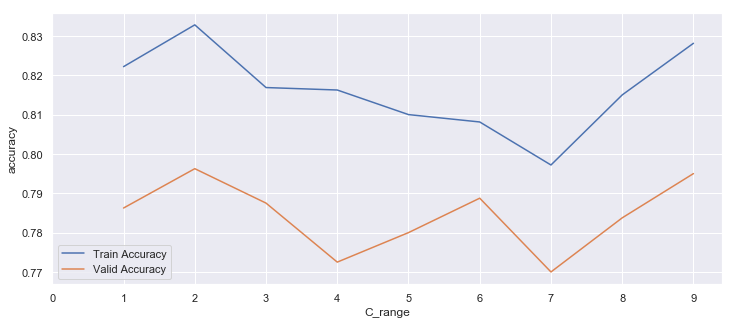

In [8]:
# Plot test curve
plt.figure( figsize=(12, 5))
plt.plot(svm_lin_test_scores_df.C_range, svm_lin_test_scores_df.Train_accuracy, label='Train Accuracy')
plt.plot(svm_lin_test_scores_df.C_range, svm_lin_test_scores_df.Valid_accuracy, label='Valid Accuracy')
plt.xlabel('C_range')
plt.ylabel('accuracy')
# x-ticks  for single k values
plt.xticks(np.arange(Maximum_C), np.arange(Maximum_C))
plt.legend()
plt.show()

In [9]:
# Print maximum accuracy without cross-validation
#print(test_scores_df)
idx = svm_lin_test_scores_df.Valid_accuracy.idxmax() # Index of maximum value
max_accuracy = svm_lin_test_scores_df.Valid_accuracy[idx]
best_C = svm_lin_test_scores_df.C_range[idx]
print('Top accuracy on validation set:  {:.3f} with C= {}'
      .format(max_accuracy, best_C))

Top accuracy on validation set:  0.796 with C= 2


In [10]:
#grid search with cross-validation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Create pipeline
pipe = Pipeline([
    ('scaler', None), # Optional step
    ('logreg', LogisticRegression())
])

# Create cross-validation object
grid_cv = GridSearchCV(pipe, [{
    'logreg__multi_class': ['ovr'],
    'logreg__C': [0.1, 1, 10],
    'logreg__solver': ['liblinear']
}], n_jobs=-1, cv=5)

# Fit estimator
grid_cv.fit(X_tr2, y_tr2)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', None), ('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'logreg__multi_class': ['ovr'], 'logreg__C': [0.1, 1, 10], 'logreg__solver': ['liblinear']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [11]:
grid_cv.best_score_

0.825625

In [12]:
grid_cv.best_params_

{'logreg__C': 0.1, 'logreg__multi_class': 'ovr', 'logreg__solver': 'liblinear'}

In [13]:
# Collect results in a DataFrame
df = pd.DataFrame.from_items([
    ('C', grid_cv.cv_results_['param_logreg__C']),
    ('multi_class', grid_cv.cv_results_['param_logreg__multi_class']),
    ('mean accuracy', grid_cv.cv_results_['mean_test_score']),
    ('standard deviation', grid_cv.cv_results_['std_test_score'])
])
df.sort_values(by='mean accuracy', ascending=False)

C:\Users\x\Anaconda3\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


,C,multi_class,mean accuracy,standard deviation
0,0.1,ovr,0.825625,0.018556
1,1,ovr,0.825000,0.019961
2,10,ovr,0.824063,0.019630


In [14]:
# Print maximum accuracy
idx = df['mean accuracy'].idxmax() # Index of maximum value
df1=df['mean accuracy']
max_accuracy = df1[idx]
df2=df['standard deviation']
df2_std = df2[idx]
best_lin_C = df.C[idx]
print('Linear SVM - top accuracy across folds: {:.4f} (std: {:.4f}) with C: {:.2f}'
      .format(max_accuracy, df2_std, best_lin_C))

Linear SVM - top accuracy across folds: 0.8256 (std: 0.0186) with C: 0.10


# second task
Create an SVM classifier with an RBF kernel. Tune its C and y parameters.

In [15]:
# Create SVM with RBF kernel.
#grid search without cross-validation
from sklearn.svm import SVC
from sklearn.model_selection import ParameterGrid
gamma_range = [0.01,0.1,1] 
grid = ParameterGrid({'gamma_range': gamma_range})
svm_rbf_test_scores = []

for i, params_dict  in enumerate(grid, 1):
    # Print progress
    print('Combination {}/{}'.format(
        i, len(grid) # Total number of combinations
    ))
    
    rbf_svc = SVC(kernel='rbf', C=6, gamma=i, random_state=0)

    # Fit estimator
    rbf_svc.fit(X_tr2, y_tr2)
        
    # Get train/test scores
    params_dict['Train_accuracy'] = rbf_svc.score(X_tr2, y_tr2)
    params_dict['Valid_accuracy'] = rbf_svc.score(X_valid2, y_valid2)
    print('Train accuracy: {:.3f}'.
          format(params_dict['Train_accuracy']),
          'Test accuracy: {:.3f}'
          .format(params_dict['Valid_accuracy']))

    # Save result
    svm_rbf_test_scores.append(params_dict)

print('done')

# Create DataFrame with scores
svm_rbf_test_df_scores=pd.DataFrame(svm_rbf_test_scores)
print(svm_rbf_test_df_scores)

Combination 1/3
Train accuracy: 1.000 Test accuracy: 0.251
Combination 2/3
Train accuracy: 1.000 Test accuracy: 0.250
Combination 3/3
Train accuracy: 1.000 Test accuracy: 0.250
done
   Train_accuracy  Valid_accuracy  gamma_range
0             1.0         0.25125         0.01
1             1.0         0.25000         0.10
2             1.0         0.25000         1.00


In [16]:
#grid search with cross-validation
#iterated figures (C, gamma) for best accuracy
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Create pipeline
pipe = Pipeline([
    ('scaler', None), # Optional step
    ('SVC', SVC())
])

# Create cross-validation object
grid_cv = GridSearchCV(pipe, [{
    'SVC__kernel': ['rbf'],
    'SVC__C': [5,6,7,8,9],
    'SVC__gamma': [0.00005,0.00008,0.0001,0.0005],
    #'max_iter': [100],
    #'random_state': [0]
}], n_jobs=-1, cv=5)

# Fit estimator
print(grid_cv.fit(X_tr2, y_tr2))

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', None), ('SVC', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'SVC__kernel': ['rbf'], 'SVC__C': [5, 6, 7, 8, 9], 'SVC__gamma': [5e-05, 8e-05, 0.0001, 0.0005]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


In [17]:
grid_cv.best_score_

0.839375

In [18]:
grid_cv.best_params_

{'SVC__C': 5, 'SVC__gamma': 8e-05, 'SVC__kernel': 'rbf'}

In [19]:
# Collect results in a DataFrame
df = pd.DataFrame.from_items([
    ('C', grid_cv.cv_results_['param_SVC__C']),
    ('gamma', grid_cv.cv_results_['param_SVC__gamma']),
    ('mean accuracy', grid_cv.cv_results_['mean_test_score']),
    ('standard deviation', grid_cv.cv_results_['std_test_score'])
])
df.sort_values(by='mean accuracy', ascending=False)

C:\Users\x\Anaconda3\envs\exts-aml2\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


,C,gamma,mean accuracy,standard deviation
1,5,8e-05,0.839375,0.016518
10,7,0.0001,0.838125,0.018318
6,6,0.0001,0.837812,0.017990
18,9,0.0001,0.837500,0.017650
5,6,8e-05,0.837500,0.018724
14,8,0.0001,0.836875,0.017639
2,5,0.0001,0.836875,0.016286
17,9,8e-05,0.836875,0.020363
8,7,5e-05,0.836875,0.019853
9,7,8e-05,0.836250,0.020715


In [20]:
# Print maximum accuracy
idx = df['mean accuracy'].idxmax() # Index of maximum value
df1=df['mean accuracy']
max_RBF_accuracy = df1[idx]
df2=df['standard deviation']
df2_std = df2[idx]
best_RBF_C = df.C[idx]
df3=df['gamma']
best_RBF_gamma = df3[idx]
print('RBF SVM - top accuracy across folds: {:.4f} (std: {:.4f}) with C: {:.2f} and gamma:{:.5f}'
      .format(max_RBF_accuracy, df2_std, best_RBF_C,best_RBF_gamma))

RBF SVM - top accuracy across folds: 0.8394 (std: 0.0165) with C: 5.00 and gamma:0.00008


# Third task
Finally, evaluate and report the accuracy of your (tuned) estimators on the 1,000 points
from the test set.

In [21]:
# Linear SVM accuracy
linear_svc = LinearSVC(C=best_lin_C, random_state=0)
linear_svc.fit(X_tr, y_tr)
linear_svc_score=linear_svc.score(X_te, y_te)

print('Linear SVM accuracy (test set): {:.4f}'.format(linear_svc_score))

Linear SVM accuracy (test set): 0.8020


In [22]:
# RBF SVM accuracy
RBF_svc = SVC(kernel='rbf',C=best_RBF_C, gamma=best_RBF_gamma, random_state=0)
RBF_svc.fit(X_tr, y_tr)
RBF_svc_score=RBF_svc.score(X_te, y_te)

print('RBF SVM accuracy (test set): {:.4f}'.format(RBF_svc_score))

RBF SVM accuracy (test set): 0.8390


In [23]:
# Load data & Save Results
Result_df = pd.read_csv('Result_df.csv')
print(Result_df.head(9))

           model  test accuracy
0           k-NN          0.794
1  decision tree          0.658
2  random forest          0.797
3     svm linear          0.797
4        svm rbf          0.842
5       logistic          0.810
6          fc nn          0.839
7            cnn          0.816


In [25]:
Result_df.iloc[3,1]=linear_svc_score
Result_df.iloc[4,1]=RBF_svc_score
print(Result_df.head(9))
#Write Result as Dataframe to file
Result_df.to_csv('Result_df.csv', index=False, float_format='%.3f')

           model  test accuracy
0           k-NN          0.794
1  decision tree          0.658
2  random forest          0.797
3     svm linear          0.802
4        svm rbf          0.839
5       logistic          0.810
6          fc nn          0.839
7            cnn          0.816
